<a href="https://colab.research.google.com/github/martinpius/Practicals/blob/main/Big_data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# # Install Java
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null

# # Download Spark from a working mirror
# !wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# # Extract the Spark tar file
# !tar -xvzf spark-3.4.1-bin-hadoop3.tgz > /dev/null

# Install findspark
!pip install -q findspark


In [2]:
#!rm -f spark-3.4.1-bin-hadoop3.tgz

In [ ]:
# Setting up Spark_home and Jave_home in CoL

In [8]:
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

In [ ]:
# Import

In [10]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.linalg import DenseVector, SparseVector
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# Spark MLlib
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [11]:
# Start the Spark session
spark = SparkSession.builder.master("local[*]").appName("TextClassification").getOrCreate()

In [12]:
# Fetch dataset
data = fetch_20newsgroups(subset='all', shuffle=True, remove=('headers', 'footers', 'quotes'))


In [13]:
for key, value in data.items():
    print(key)

data
filenames
target_names
target
DESCR


In [15]:
data.data[:3]

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [ ]:
#data.data[:3]

In [17]:
# Create pandas DataFrame
pdf = pd.DataFrame({'text': data.data, 'label': data.target})


In [19]:
display(pdf.head(5))

,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [21]:
# Convert to Spark DataFrame for para
df = spark.createDataFrame(pdf)
df.show(5, truncate=1000)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# Tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")


In [23]:
# Remove stopwords eg (and, the, or , etc)
remover = StopWordsRemover(inputCol="words", outputCol="filtered")



In [24]:
# HashingTermFreq - converts words to fixed-length feature vectors
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)


In [28]:

# InvDocFre - downscale frequent words[less impor]
idf = IDF(inputCol="rawFeatures", outputCol="features")



In [26]:
# Create Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])



In [27]:
# Fit and transform the data
pipeline_model = pipeline.fit(df)
processed_df = pipeline_model.transform(df)


In [29]:
# Select only the necessary columns
processed_df.select("label", "features").show(5, truncate=True)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|   10|(10000,[453,524,6...|
|    3|(10000,[85,126,22...|
|   17|(10000,[39,136,15...|
|    3|(10000,[53,126,38...|
|    4|(10000,[228,302,4...|
+-----+--------------------+
only showing top 5 rows



In [30]:
processed_df.count()

18846

In [31]:
# Sample ~2000 rows to keep t-SNE fast
sampled = processed_df.select("label", "features").limit(2000)

# Convert to Pandas DataFrame
pandas_df = sampled.toPandas()



In [32]:
display(pandas_df.head(3))

,label,features
0,10,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,17,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:

# Convert features (SparseVector) to dense NumPy arrays
def vector_to_array(v):
    if isinstance(v, SparseVector):
        return v.toArray()
    return np.array(v)

X = np.vstack(pandas_df['features'].apply(vector_to_array))
y = pandas_df['label'].values

In [35]:
X.shape

(2000, 10000)

In [36]:
# t-[SNE-t-distributed Stochastic Neighbor Embedding.] dimensionality reduction[visuzlizing hig dm data]
tsne = TSNE(n_components=2, random_state=1965, perplexity=45) #Perplexity  ranges from 5-50, high(50)->global r/ship
X_embedded = tsne.fit_transform(X)


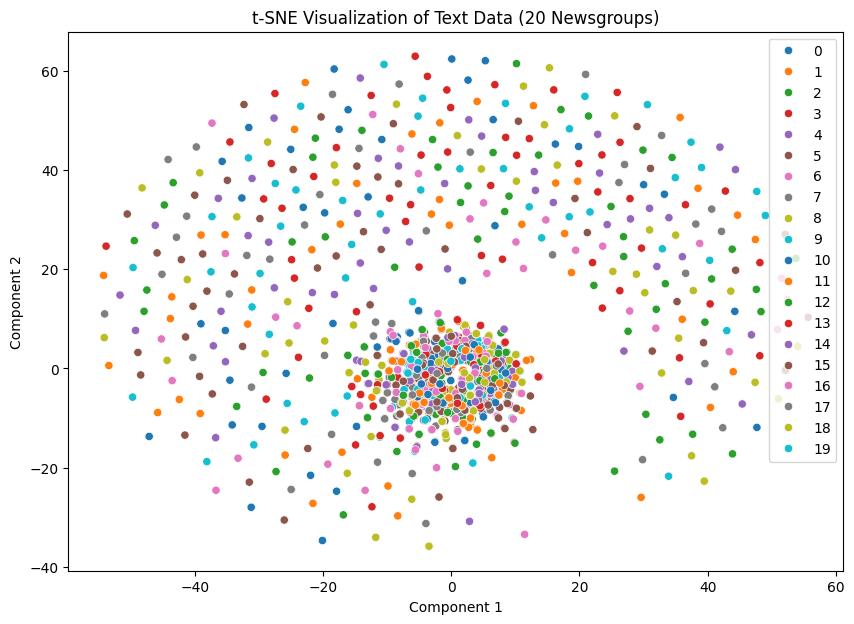

In [37]:
# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="tab10", legend='full')
plt.title("t-SNE Visualization of Text Data (20 Newsgroups)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [38]:
# Prepare final dataset (label + features only)
final_data = processed_df.select("label", "features")

# Split into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed= 1234)



In [45]:
# Define logistic regression model
lr = LogisticRegression(maxIter=20, regParam=0.1) #



In [46]:
# Train model
lr_model = lr.fit(train_data)



In [47]:
# Make predictions
predictions = lr_model.transform(test_data)



In [48]:
# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Set Accuracy = {accuracy:.4f}")

Test Set Accuracy = 0.5939
